# Brain Activity, Stimulation Timecourse, and Tail Movement Data Ingest

This jupyter notebook will walk through reading in the live datasets.

We will begin with some standard imports and setup.

In [2]:
# standard imports
from __future__ import annotations
import os
import numpy as np
import ipynbname
import matplotlib as mpl
import matplotlib.dates
import matplotlib.ticker
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

# local imports
import c_swain_python_utils as csutils
from utilities import *

sns.set_style('ticks')

_file = ipynbname.path()
_name = csutils.no_ext_basename(_file)
jobs_dir = os.path.split(_file)[0]
sources_dir = os.path.abspath(os.path.join(jobs_dir, '..'))
repo_dir = os.path.abspath(os.path.join(sources_dir, '..'))
config_dir = os.path.abspath(os.path.join(repo_dir, 'configs'))
data_dir = os.path.abspath(os.path.join(repo_dir, 'data'))

In [3]:
# LOGGER
log = csutils.get_logger(_name)

# logging setup
debug_mode = False
default_window_level = 'info'

log_path = os.path.join(sources_dir, '..', 'logs', f'{_file}.log')
csutils.apply_standard_logging_config(
    file_path=None,
    window_level='debug' if debug_mode else default_window_level,
    window_format='debug' if debug_mode else 'default')

In [4]:
log.info('Loading Config...')
config_name = 'cs-ii-29_pre-proc-live-data_config'
config_path = os.path.join(config_dir, f'{config_name}.yml')
config = ZMIAConfig(config_path)

log.info('Loading dataset information objects...')

brain_activity_dsi = config.get_dataset_info(
    name='cs-ii-29B_r399_regional-brain-activity-timecourses')
region_props_dsi = config.get_dataset_info(
    name='cs-ii-29B_r399_brain-region-properties')

fish_movement_dsi = config.get_dataset_info(
    name='cs-ii-29b_r399_fish-movement-timecourses')

stim_control_dsi = config.get_dataset_info(
    name='cs-ii-29B_r399_stimulation-control-timecourses')
flow_sense_dsi = config.get_dataset_info(
    name='cs-ii-29B_r399_stimulation-flow-sensor-timecourses')


log.info('Done.')

local-nb_cs-ii-29_live-data-ingest-plot (   1): INFO : Loading Config...


utilities ( 218): WARNING : Input data directory in configuration file does not exist
"..\cs-ii-29_pre-proc".


local-nb_cs-ii-29_live-data-ingest-plot (   6): INFO : Loading dataset information objects...
local-nb_cs-ii-29_live-data-ingest-plot (  22): INFO : Done.



## 1. Regional Brain Activity Data

The regional activity brain data is acquired by:
1. Acquiring volumetric timeseries data from live zebrafish larvae.
2. Importing these volumetric datasets from their file formats in to numpy `ndarray`s.
3. Aligning an [anatomical atlas] onto the live imaging data.
4. Using the anatomical atlas to segment the volumetric timeseries data into distinct anatomical regions.
5. Extract the aggregate (average) voxel intensity timcourses for each region.
6. Save the intensity timecourses into a `pandas.DataFrame`. 

These steps have already been performed prior and the data stored according to the configuration file

_Note `np.NAN` values represent regions that were not in our live data since the regional atlas occupies a larger field of view compared to our live imaging data._


In [5]:
# loading in main whole-brain calcium activity dataframe
activity_df = csutils.load_from_disk(brain_activity_dsi.full_path)

# displaying the first 100 rows and first 100 columns of the dataframe
activity_df.iloc[:100, :20]

FileNotFoundError: [Errno 2] No such file or directory: '..\\cs-ii-29_pre-proc\\cs-ii-29_fish-B_run-399_ca-activity-vs-time-by-region.pkl'

In [6]:
# loading in brain region properties
region_prop_df = csutils.load_from_disk(region_props_dsi.full_path)

# displaying the first 100 rows of the dataframe
region_prop_df.iloc[:100, :]

FileNotFoundError: [Errno 2] No such file or directory: '..\\cs-ii-29_pre-proc\\cs-ii-29_fish-B_run-399_size-and-loc-vs-region.pkl'

### Scheme for Computing $\frac{\Delta f}{f}$

I'll outline in symbolic form and pseudo-code the scheme for performing the $\frac{\Delta f}{f}$ computation. It will be left as an implementation exercise to perform this computation in code.

Let's consider that the mean fluroescent timecourse for a region $n$ is given by:
$$
f_n\left(t\right)
$$ 

We will first apply some gaussian smoothing to the raw timecourse.
$$
f_{n,\text{smooth}}\left(t\right) = \texttt{gaussian_filter}\left(f_n\left(t\right),\ \sigma\right)
$$ 
where $\sigma$ is the width of the smoothing kernal; use $ \sigma = 1\ \text{second} $ for now. 

We'll now need to compute the baseline florescence for the region. For a nieve approach, we can simply use the minimum value 
$$
f_{n,\text{baseline-simple}} = \texttt{min}\left(f_{n,\text{smooth}}\left(t\right)\right)
$$

However, this method is not robust to noise or to baseline drift over the course of the acquisition session. Instead, we can compute a moving (or rolling) quantile as a starting point for the baseline:
$$
f_{n,\text{rolling-qt}}\left(t\right) = \texttt{rolling_quantile}\left(f_{n,\text{smooth}}\left(\right),\ \texttt{quantile}=q,\ \texttt{size}=W\right)
$$  
Where we can utilize a quantile value $q = 0.05$ and a rolling window size $W= 3\ \text{minute}$.

As an additional step we can clamp the rate at which this baseline value can change and utilize that to prevent too much drift of the baseline value over time.

$$
f_{n,\text{drift-limited}}\left(t\right) = A + 
\texttt{cumsum} \left(
\texttt{clip} \left(
\texttt{diff} \left(
f_{n,\text{rolling-qt}}\left(t\right)\right),
\ \texttt{min}=-r_{\text{max}},
\ \texttt{max}=r_{\text{max}}
\right)
\right)
$$

Where 
$$r_{\text{max}} = \left( 30 \times 10^{-6} \frac{1}{\text{second}}\right) \Delta t 
$$, $\Delta t$ is the temporal sampling period for the activity timecourses, and $A$ is chosen such that the following equation holds:
$$
\texttt{min}\left(f_{n,\text{rolling-qt}}\left(t\right)\right) = \texttt{min}\left(f_{n,\text{drift-limited}}\left(t\right)\right)
$$

To prevent negative values from appearing in the final result, let's clip the smoothed activty timecourses to the baseline value with the following algorithm:

$$
\texttt{clip_filter}\left(t\right) \leftarrow f_{n,\text{smooth}}\left(t\right) < f_{n,\text{drift-limited}}\left(t\right)
$$
$$
f_{n,\text{smooth-clip}}\left(t\right)  \leftarrow f_{n,\text{smooth}}\left(t\right)
$$
$$
f_{n,\text{smooth-clip}}\left[\texttt{clip_filter}\right]  \leftarrow f_{n,\text{drift-limited}}\left[\texttt{clip_filter}\right]
$$
where $\texttt{clip_filter}$ is a boolean array which can be used to index timecourses.

Now to compute the final normalized result, we can apply the following equation:
$$
f_{n,\text{norm}}\left(t\right) = \frac{f_{n,\text{smooth-clip}}\left(t\right) - f_{n,\text{drift-limited}}\left(t\right)}{f_{n,\text{drift-limited}}\left(t\right)}
$$ 


An example figure for each of the outputs is shown below:
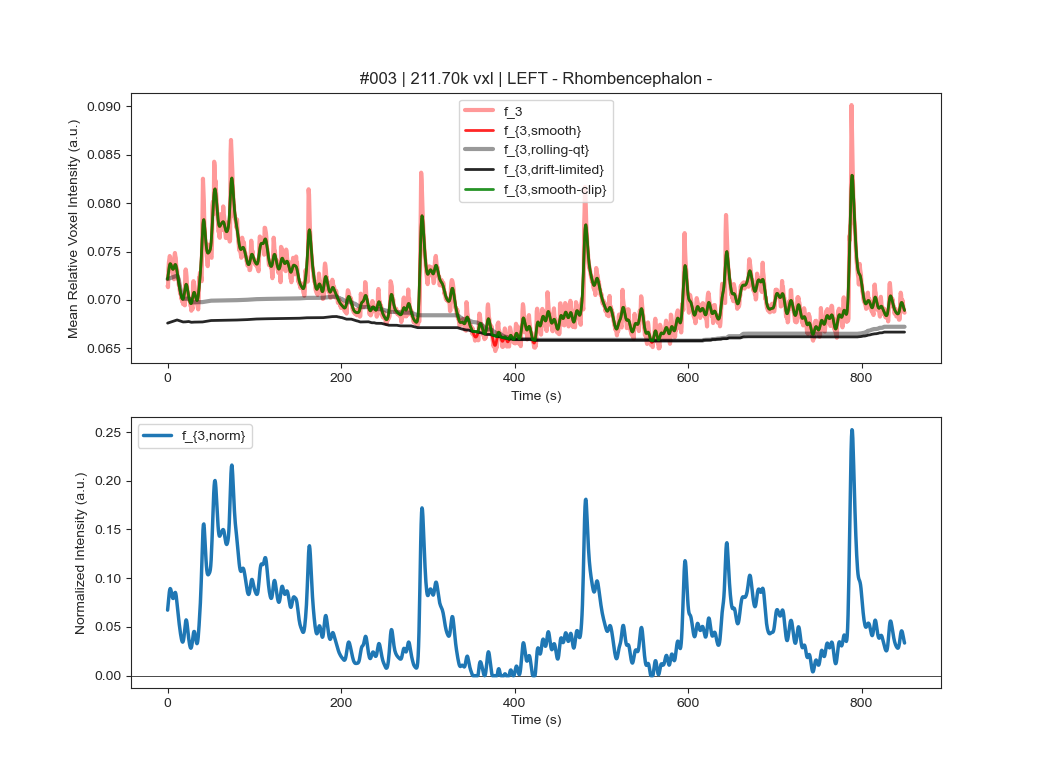

## 2. Tail Angle Data

The tail angle data is acquired by:
1. Live recording of zebrafish tail movements using an infared camera and illumination source.
2. Conversion of raw video data into a video file and a timecode file.
3. Processing of the video file through [ZebraZoom](https://zebrazoom.org/) to extract tail angle quantification.
4. Import of zebrazoom analysis `.csv` table and combining it with the video timecode.
5. Resampling of tail angle data to regular intervals.
6. Detection of tail movement at various threshold levels. 
7. Export of resampled data and bout flagged-data into a `pandas.DataFrame`. 

In [ ]:
# reading in tail angle data using dataset information
tail_angle_df = csutils.load_from_disk(fish_movement_dsi.full_path)

# displaying the first 100 rows of the dataframe
tail_angle_df.iloc[:100, :]

## 3. Stimulation Data

The stimulation data is recorded as follows:
1. Trigger timepoints are logged by the stimulation control computer
2. Solenoid status at each time point is manually provided.
3. Solenoid status and stimulation status at each timepoint is exported into a `pandas.DataFrame`.

In [ ]:
# reading in the stimulation control signals
stim_control_df = csutils.load_from_disk(stim_control_dsi.full_path)

# displaying the full dataframe
stim_control_df

In [ ]:
# reading in the stimulation flow sensor data signals
flow_sense_df = csutils.load_from_disk(flow_sense_dsi.full_path)

# displaying the first 100 rows and 10 columns of the dataframe
flow_sense_df.iloc[:100, :10]

## Plot of Most Data


In [ ]:
# FIXME - not yet working

%matplotlib qt

# Regional Activity Plot

fig = plt.figure(figsize=(20, 12))

ax_hmap = sns.heatmap(
    activity_df.T,
    cmap='rocket',
    cbar=None,
    robust=True)

hmap_pos_0 = ax_hmap.get_position()

top_margin = 0.04
new_height = hmap_pos_0.height * 0.7

ref_x_pos = hmap_pos_0.x0
ref_width = hmap_pos_0.width

ax_hmap.set_title('ACTIVITY: Zebrafish Functional Ca++ Imaging Heatmap by Brain Region '
                  '(regions clustered with correlation metric based on activity)'
                  ' | Experiment CS-II-29A_RUN-399')

ax_hmap.set_position(
    [hmap_pos_0.x0, 1 - new_height - top_margin,
     hmap_pos_0.width, new_height])


# ax_hmap.set_xlim([0, adj_unix_time_array.max()])
# ax_hmap.sharey(ax_row_dgram)
# ax_hmap.xaxis.set_major_locator(
#     mpl.ticker.AutoLocator())
# ax_hmap.tick_params(
#     axis='both', 
#     which='both',
#     length=5)
# ax_hmap.xaxis.set_tick_params(labelbottom=True)
# y_labels_raw = functional_activity_df.columns.to_list() 
# y_labels = [y_labels_raw[i] for i in 
#             clst_grd.dendrogram_row.reordered_ind]
# ax_hmap.yaxis.set_ticks(
#     ticks=y_locs_for_dendrogram,
#     labels=y_labels)
# plt.setp(ax_hmap.get_xticklabels(),
#          rotation='horizontal')
# 
# def sec_formatter(x, pos):
#     x_min, x_sec = np.divmod(x, 60)
#     x_min = x_min.astype(int)
#     x_str = f'{x_min:02d}:{x_sec:04.1f}'
#     return x_str
# 
# ax_hmap.xaxis.set_major_formatter(
#     mpl.ticker.FuncFormatter(sec_formatter))

sns.despine(
    ax=ax_hmap,
    left=False,
    top=False,
    bottom=False,
    right=False)

# Sensor Subplot
sensor_subp_height = 0.175
subp_space = 0.055

new_pos = [
    ref_x_pos, 1 - new_height - top_margin - subp_space - sensor_subp_height,
    ref_width, sensor_subp_height]

ax_sensor = fig.add_subplot(
    position=new_pos,
    sharex=ax_hmap)

ax_sensor.plot(
    flow_sense_df.index,
    flow_sense_df.loc[:, 'flow-mlpm01'],
    'k',
    label=f'Flow Sensor, Channel #2',
    lw=2)

ax_sensor.set_ylim(ax_sensor.get_ylim())

ax_sensor.fill_between(
    stim_control_df.index,
    np.ones(shape=stim_control_df.loc[:, 'solenoid_01_open'].shape) * (-1E3),
    (stim_control_df.loc[:, 'solenoid_01_open'] * 2E3) - 1E3,
    alpha=0.2,
    label='Control Signal, Solenoid #2')

ax_sensor.set_xlabel('Time (m:s)')
ax_sensor.set_ylabel('Flow Rate (ml/min)')
ax_sensor.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1))
ax_sensor.set_title('STIMULATION: Flow Rate vs. Time (tactile pulses of water, no odor)')

# Tail Angle Subplot
tail_subp_height = 0.175

new_pos = [
    ref_x_pos, 
    1 - new_height - top_margin - subp_space - sensor_subp_height - subp_space - tail_subp_height,
    ref_width,
    tail_subp_height]

ax_tail = fig.add_subplot(
    position=new_pos,
    sharex=ax_hmap)

ax_tail.plot(
    tail_angle_df.index, 
    tail_angle_df.loc[:, 'tail_angle'],
    'k',
    label='Tail Angle, Smoothed',
    lw=2)

ax_sensor.fill_between(
    stim_control_df.index,
    np.ones(shape=stim_control_df.loc[:, 'solenoid_01_open'].shape) * (-1E3),
    (stim_control_df.loc[:, 'solenoid_01_open'] * 2E3) - 1E3,
    alpha=0.2,
    label='Control Signal, Solenoid #2')

ax_tail.fill_between(tail_angle_df.index,
                 np.ones(tail_angle_df.loc[:, 'bout_detection_1000'].shape) * (-180),
                 (tail_angle_df.loc[:, 'bout_detection_1000'] * 360) - 180,
                 color='r',
                 alpha=0.5,
                 label='Bout Detection (1.85 deg threshold)')
ax_tail.set_ylim([-180, 180])

ax_tail.hlines(y=0, 
               xmin=0,
               xmax=stim_control_df.index.max(),
               linestyles=':',
               colors='k')

ax_tail.set_xlabel('Time (m:s)')
ax_tail.set_ylabel('Tail Angle (deg)')
ax_tail.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1))
ax_tail.set_title('BEHAVIOR: Tail Angle vs. Time, Quantified from IR Imaging Camera')

plt.show()